In [1]:
import config
import requests
import pandas as pd
import json
import time
from pandas import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', palette='dark')

## Authenticate with Strava

In [2]:
with open('strava_tokens.json') as json_file:
    strava_tokens = json.load(json_file)

if strava_tokens['expires_at'] < time.time():
    response = requests.post(
                        url = 'https://www.strava.com/oauth/token',
                        data = {
                                'client_id': config.client_id,
                                'client_secret': config.client_secret,
                                'grant_type': 'refresh_token',
                                'refresh_token': strava_tokens['refresh_token']
                                }
                    )
    new_strava_tokens = response.json()

    with open('strava_tokens.json', 'w') as outfile:
        json.dump(new_strava_tokens, outfile)

    strava_tokens = new_strava_tokens

In [3]:
with open('strava_tokens.json') as check:
  data = json.load(check)

In [4]:
# Get the tokens from the file to connect to Strava
with open('strava_tokens.json') as json_file:
    strava_tokens = json.load(json_file)

# Loop through all activities
url = "https://www.strava.com/api/v3/activities"
access_token = strava_tokens['access_token']

# Get the first page of activities from Strava with all fields
r = requests.get(url + '?access_token=' + access_token)
r = r.json()
    
df = json_normalize(r)
df.to_csv('strava_activities_all_fields.csv')

## Data Retrieval

In [5]:
# Using the Strava API with a specific header to retrive activity data
header = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page': 1}
r = requests.get(url, headers=header, params=param).json()

In [6]:
activities = json_normalize(r)

# new dataframe with desired columns
columns = [
            "id",
            "name",
            "start_date_local",
            "type",
            "distance",
            "moving_time",
            "elapsed_time",
            "total_elevation_gain",
            "end_latlng",
            "location_country",
            "flagged",
            "has_heartrate",
            "average_heartrate",
            "max_heartrate",
            "average_speed",
            "map.summary_polyline"
    ]

activities = activities[columns]

# Export activities file as a csv 
# to the folder this script runs in
activities.to_csv('strava_activities.csv')

## Data Exploration

Now that that activity data is retrieved and stored as a .csv file, and as a pandas DataFrame (df), we can inspect the head of the df to get an idea of how the data looks:

In [7]:
activities.head()

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,end_latlng,location_country,flagged,has_heartrate,average_heartrate,max_heartrate,average_speed,map.summary_polyline
0,6598004451,Morning Run,2022-01-29T09:57:57Z,Run,6444.5,1978,2030,52.1,"[41.960498029366136, 3.0399949103593826]",Spain,False,True,144.9,168.0,3.258,sgb_GuppQUAGDWBk@`@@`@MBi@pAYTQH]WQ?e@G]b@]Ca@...
1,6589161188,Lunch Run,2022-01-27T12:17:24Z,Run,9846.4,2962,2972,12.6,"[41.96275033056736, 3.0380767956376076]",Spain,False,True,155.7,168.0,3.324,}mb_GmjpQ_@]e@EGDELGDcAIeBg@w@QgA]{AUeBMQ?u@Hy...
2,6573787184,Burn Baby,2022-01-24T12:48:09Z,Run,6444.1,1893,1934,11.4,"[41.96095953695476, 3.038990255445242]",Spain,False,True,160.2,181.0,3.404,okb_GorpQAHd@bAHJDNCFWXWf@i@d@[MYFICK?}@ZYCu@U...
3,6559064384,Afternoon Run,2022-01-21T14:38:44Z,Run,9944.9,3022,3510,56.3,"[41.96046022698283, 3.040398834273219]",Spain,False,True,149.3,174.0,3.291,olb_GukpQKB_@ZCLOGC@UK]?QLW^Oh@KVC@UEi@YiBg@iB...
4,6538818076,Afternoon Run,2022-01-17T17:06:26Z,Run,9663.8,2963,3133,54.1,"[41.96291017346084, 3.0405751056969166]",Spain,False,True,149.5,169.0,3.261,slb_GsjpQDMAEIESCeA?i@R]hASXa@Ia@AkAQ_Ck@_AQiA...


## Data Conversion

Often when working with raw data, some of the data types are not in a format that is convenient. For example, most long distance runners prefer to work in miles and not kilometers. This means that pace data also needs to be converted from min/km to min/mile. Also, days of the week data could be useful, so new day of the week columns and month of the year coolumns can be created. Finally, the datatype sometimes need to be changed, in the example below we change a datetime column into a timedelta column

In [8]:
# Create a distance in miles column
conv_fac_kilometers_miles = 0.621371 # conversion factor
activities['distance_miles'] = (activities['distance']*conv_fac_kilometers_miles)/1e3

# Convert m/s to min/mile
activities['minute_mile'] = 1/(activities['average_speed']/26.822)

# Convert dates to datetime type
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])

# Create a day of the week and month of the year columns
activities['day_of_week'] = activities['start_date_local'].dt.day_name()
activities['month_of_year'] = activities['start_date_local'].dt.month
activities['week_of_year'] = activities['start_date_local'].dt.isocalendar().week

# Convert times to timedeltas
activities['moving_time'] = pd.to_timedelta(activities['moving_time'])
activities['elapsed_time'] = pd.to_timedelta(activities['elapsed_time'])

# Convert start date to years
activities['year'] = pd.DatetimeIndex(activities['start_date_local']).year

activities.head()

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,end_latlng,location_country,...,average_heartrate,max_heartrate,average_speed,map.summary_polyline,distance_miles,minute_mile,day_of_week,month_of_year,week_of_year,year
0,6598004451,Morning Run,2022-01-29 09:57:57+00:00,Run,6444.5,0 days 00:00:00.000001978,0 days 00:00:00.000002030,52.1,"[41.960498029366136, 3.0399949103593826]",Spain,...,144.9,168.0,3.258,sgb_GuppQUAGDWBk@`@@`@MBi@pAYTQH]WQ?e@G]b@]Ca@...,4.004425,8.232658,Saturday,1,4,2022
1,6589161188,Lunch Run,2022-01-27 12:17:24+00:00,Run,9846.4,0 days 00:00:00.000002962,0 days 00:00:00.000002972,12.6,"[41.96275033056736, 3.0380767956376076]",Spain,...,155.7,168.0,3.324,}mb_GmjpQ_@]e@EGDELGDcAIeBg@w@QgA]{AUeBMQ?u@Hy...,6.118267,8.069194,Thursday,1,4,2022
2,6573787184,Burn Baby,2022-01-24 12:48:09+00:00,Run,6444.1,0 days 00:00:00.000001893,0 days 00:00:00.000001934,11.4,"[41.96095953695476, 3.038990255445242]",Spain,...,160.2,181.0,3.404,okb_GorpQAHd@bAHJDNCFWXWf@i@d@[MYFICK?}@ZYCu@U...,4.004177,7.879553,Monday,1,4,2022
3,6559064384,Afternoon Run,2022-01-21 14:38:44+00:00,Run,9944.9,0 days 00:00:00.000003022,0 days 00:00:00.000003510,56.3,"[41.96046022698283, 3.040398834273219]",Spain,...,149.3,174.0,3.291,olb_GukpQKB_@ZCLOGC@UK]?QLW^Oh@KVC@UEi@YiBg@iB...,6.179472,8.150106,Friday,1,3,2022
4,6538818076,Afternoon Run,2022-01-17 17:06:26+00:00,Run,9663.8,0 days 00:00:00.000002963,0 days 00:00:00.000003133,54.1,"[41.96291017346084, 3.0405751056969166]",Spain,...,149.5,169.0,3.261,slb_GsjpQDMAEIESCeA?i@R]hASXa@Ia@AkAQ_Ck@_AQiA...,6.004805,8.225084,Monday,1,3,2022


## Get Only Half Marathon Training Activities

Here, the actual race day data is excluded, as for now we only want to look at the training data.

In [9]:
# date range for the training of the half marathon, excluding the actual race day
start_date_training = '2021-10-23'
end_date_training = '2021-12-04'

mask_training = (activities['start_date_local'] > start_date_training) & (activities['start_date_local'] <= end_date_training)
df_training = activities.loc[mask_training]

# date for the race day
date_race = '2021-12-05'
date_race2 = '2021-12-06'
mask_race = (activities['start_date_local'] >= date_race) & (activities['start_date_local'] <= date_race2)
df_race = activities.loc[mask_race]

## Graphing

### Weekly Distance

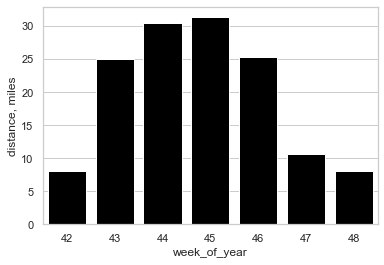

In [10]:
# Construct dataframe with week number column and values column
df2 = df_training.loc[:, ["distance_miles"]]
df2["week_of_year"] = activities['week_of_year']

# Sum up weekly values
df3 = (
    df2
    .groupby("week_of_year")
    .sum()
    .reset_index()
)

ax = sns.barplot(x='week_of_year', y='distance_miles', data=df3, color = 'black')
ax.set(xlabel="week_of_year", ylabel = "distance, miles")

plt.show()

In [11]:
print("Total miles ran in training:", round(sum(df_training['distance_miles'])))

Total miles ran in training: 139


#### Weekly distance plan

The training consisted of an easy first week, followed by 4 weeks of 25 miles or above per week, peaking at around 31 miles a week, and then into an aggressive two week taper running at a distance of approximately 60 percent less than the proceeding 4 weeks average. A total of 139 miles was ran in the training period before the Half Marathon.

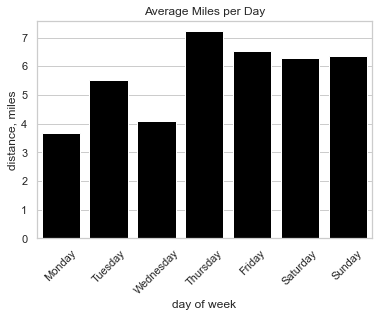

In [12]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]

ax = sns.barplot(x='day_of_week', y='distance_miles', data=df_training, order=days_of_week, ci=None, color='black')
ax.set(xlabel="day of week", ylabel = "distance, miles", title = "Average Miles per Day")
plt.xticks(rotation=45)
plt.show()

#### Days of the week analysis

The first half of the week (Monday to Wednesday) where lighter distance days, when compared to the later half (Thursday to Sunday). There was no predefined plan for this, it just happened that after 4 days of longer runs, the proceeding 3 days where run at lower distance. This variation could have helped with recovery between long runs. However, the shorter runs where ran faster, in order to build speed.

### Pacing

The target race pace was 7:30 min / mile. Most of the training that occurred in the 6 week period before race day was done above race pace. There where two exceptions, where the average pace for the run was below race pace. This where tempo runs, designed to be run at speed.

Running distance per session ranged from 3 to 10 miles. The Half Marathon race distance (13.1 miles) was never run in training in the 6 weeks prior to race day. This was intentional. I have run marathons before and many half marathons in training, so I knew I could cover the distance. I was training to run a personal best.

To achieve this, I ran long distances above race pace and shorter distances at speed, significantly faster than race pace. This variable training type is designed to get the heart stronger, get the legs to able to move faster, as well as having the cardiovascular engine to cover the half marathon race distance.

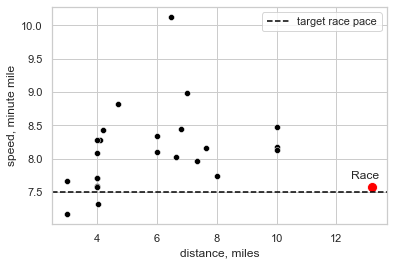

In [13]:
# training data
ax = sns.scatterplot(x='distance_miles', y='minute_mile', data=df_training, color = 'black')

# race day data
ax1 = sns.scatterplot(x='distance_miles', y='minute_mile', data=df_race, color = 'red', s=100)

ax.set(xlabel="distance, miles", ylabel = "speed, minute mile")
plt.axhline(y=7.5, color = "black", linestyle='--', label="target race pace")

# mark race data
plt.text(12.5,7.7,'Race')

plt.legend()
plt.show()

From the graph above, it can be seen that the race pace target was actually achieved on race day. The red data point represents the race day pace. Also, most runs in training are significantly above race pace, except two tempo runs. This was the plan and it appeared to work well.

### Heart Rate

Heart is a very valuable metric to observe when training for and running long distance races. Typically, the harder you run the more stress you put under the cardiovascular system. When running a long distance race, the trick is to keep your heart rate at a comfortably uncomfortable level, for me that is around 160 beats per minute (bpm). I kept my heart rate at about 160 bpm for the majority of the race, although likely towards the end it went over into the 170-180 bpm range, as for the last mile it is important to give it everything you have got left in the tank.

The heart rate data below is average only, so on tempo runs that rate would vary significantly. Usually on tempo runs I ran 4 miles, the first mile slow, the second fast, the third slow, and the final mile fast.

During the race, my heart rate was much more consistent, only spiking upwards towards the end of the race.

The graph below demonstrates that during training, my average heart rates spanned a big range, from around 130 bpm to 180 bpm. This was intentional, to expose my cardiovascular system to a wide range of hear rates.

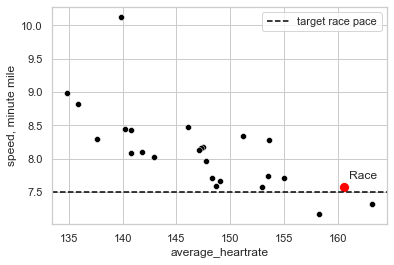

In [14]:
# training data
ax = sns.scatterplot(x='average_heartrate', y='minute_mile', data=df_training, color = 'black')

# race day data
ax1 = sns.scatterplot(x='average_heartrate', y='minute_mile', data=df_race, color = 'red', s=100)

ax.set(xlabel="average_heartrate", ylabel = "speed, minute mile")
plt.axhline(y=7.5, color = "black", linestyle='--', label="target race pace")

# mark race data
plt.text(161,7.7,'Race')

plt.legend()
plt.show()